In [1]:
import sys
from importlib import reload 
sys.path.append('./lib')

In [23]:
import utils  # expand_to_hyperboloid
utils = reload(utils)

import distances  # Distances, DistancesAggregator, ProductDistances
distances = reload(distances)
from distances import Distances, ProductDistances

import dssm  # DSSM_V2, JustEmbedding
dssm = reload(dssm)

import layers  # SphericalExponentialMapLayer, HyperbolicalExponentialMapLayer
layers = reload(layers)

In [3]:
utils.self_tests()

expand_to_hyperboloid unittest #1


In [4]:
distances.self_tests()

DistancesAggregator unittest #1...
DistancesAggregator unittest #2...
ProductDistances unittest #1...
ProductDistances unittest #2...
ProductDistances unittest #3...
ProductDistances unittest #4...
str(pd) = E2,S3,H3


In [5]:
layers.self_tests()

SphericalExponentialMapLayer UT 1
SphericalExponentialMapLayer UT 2
HyperbolicalExponentialMapLayer UT 1
HyperbolicalExponentialMapLayer UT 2


________________________

In [6]:
import networkx as nx
import numpy as np
import tensorflow as tf
import tqdm

assert int(tf.__version__.split(".")[0]) >= 2

from matplotlib import pyplot as plt
from IPython.display import clear_output

In [7]:
def make_model(l=312):
    return dssm.JustEmbedding(l, emb_size=10)

def make_model_2(emb_size=10, l=312):
    return dssm.JustEmbedding(l, emb_size=emb_size)

def make_distances(for_ranking=True):
    return [
        ProductDistances([
            (10, Distances("euclidian_corrected", scalable=False))
        ], "sum"),
        ProductDistances([
            (10, Distances("triple_trainable_l0_corrected", scalable=True))
        ], "sum"),
        ProductDistances([
            (10, Distances("triple_trainable_l1_sq_corrected", scalable=True))
        ], "sum"),
        ProductDistances([
            (10, Distances("triple_trainable_l1_corrected", scalable=True))
        ], "sum"),
        ProductDistances([
            (10, Distances("inverted_dot", scalable=True))
        ], "sum"),
        ProductDistances([
            (10, Distances("expanded_hyp", scalable=True))
        ], "sum"),
        ProductDistances([
            (10, Distances("spherical", scalable=True))
        ], "sum"),
        ProductDistances([
            (5, Distances("expanded_hyp", scalable=True)),
            (5, Distances("expanded_hyp", scalable=True)),
        ]),
        ProductDistances([
            (2, Distances("expanded_hyp", scalable=True)),
            (2, Distances("expanded_hyp", scalable=True)),
            (2, Distances("expanded_hyp", scalable=True)),
            (2, Distances("expanded_hyp", scalable=True)),
            (2, Distances("expanded_hyp", scalable=True)),
        ]),
        ProductDistances([
            (5, Distances("spherical", scalable=True)),
            (5, Distances("spherical", scalable=True)),
        ]),
        ProductDistances([
            (2, Distances("spherical", scalable=True)),
            (2, Distances("spherical", scalable=True)),
            (2, Distances("spherical", scalable=True)),
            (2, Distances("spherical", scalable=True)),
            (2, Distances("spherical", scalable=True)),
        ]),
        ProductDistances([
            (5, Distances("spherical", scalable=True)),
            (5, Distances("expanded_hyp", scalable=True)),
        ]),
        ProductDistances([
            (2, Distances("spherical", scalable=True)),
            (2, Distances("spherical", scalable=True)),
            (2, Distances("expanded_hyp", scalable=True)),
            (2, Distances("expanded_hyp", scalable=True)),
            (2, Distances("euclidian", scalable=True)),
        ]),
    ]


def make_distances_3():
    return [
        ProductDistances([
            (11, Distances("spherical", scalable=True))
        ], "sum"),
        ProductDistances([
            (6, Distances("spherical", scalable=True)),
            (6, Distances("spherical", scalable=True)),
        ]),
        ProductDistances([
            (3, Distances("spherical", scalable=True)),
            (3, Distances("spherical", scalable=True)),
            (3, Distances("spherical", scalable=True)),
            (3, Distances("spherical", scalable=True)),
            (3, Distances("spherical", scalable=True)),
        ]),
        ProductDistances([
            (6, Distances("spherical", scalable=True)),
            (5, Distances("expanded_hyp", scalable=True)),
        ]),
        ProductDistances([
            (3, Distances("spherical", scalable=True)),
            (3, Distances("spherical", scalable=True)),
            (2, Distances("expanded_hyp", scalable=True)),
            (2, Distances("expanded_hyp", scalable=True)),
            (2, Distances("euclidian", scalable=True)),
        ]),
    ]


def make_distances_exp_dot(k=1):
    return [
        ProductDistances([
            (10, Distances("exp_minus_dot", scalable=True))
        ], "sum")
        for _ in range(k)
    ]


def make_distances_4():
    # only not-corrected ttl1 metrices
    return [
        ProductDistances([
            (10, Distances("triple_trainable_l1_sq", scalable=True))
        ], "sum"),
        ProductDistances([
            (10, Distances("triple_trainable_l1", scalable=True))
        ], "sum"),
    ]

_____________


### USCA312 fake product spaces example
**(no exponential map, just default gradients & adam optimizer)**

In [46]:
_, distances_matrix = utils.get_dataset("usca312")

Loading from ../datasets/usca312.edges


In [47]:
d = make_model()
qs = d.sparse_arange(312)  # queries
# r_matrix = 1 * (distances_matrix <= 1.001)  ## BUGS EVERYWHERE
distances_matrix.shape

(312, 312)

In [48]:
distances_matrix

array([[0.   , 1.167, 1.579, ..., 1.209, 0.866, 1.112],
       [1.167, 0.   , 0.413, ..., 0.045, 1.904, 0.082],
       [1.579, 0.413, 0.   , ..., 0.37 , 2.312, 0.467],
       ...,
       [1.209, 0.045, 0.37 , ..., 0.   , 1.95 , 0.107],
       [0.866, 1.904, 2.312, ..., 1.95 , 0.   , 1.87 ],
       [1.112, 0.082, 0.467, ..., 0.107, 1.87 , 0.   ]])

In [49]:
dm_copy = np.copy(distances_matrix)
r_matrix = np.copy(distances_matrix)

for i in range(dm_copy.shape[0]):
    dm_copy[i].sort()
    r_matrix[i] = distances_matrix[i] <= dm_copy[i, 1] + 1e-3
r_matrix -= np.eye(r_matrix.shape[0])

In [50]:
distances_matrix

array([[0.   , 1.167, 1.579, ..., 1.209, 0.866, 1.112],
       [1.167, 0.   , 0.413, ..., 0.045, 1.904, 0.082],
       [1.579, 0.413, 0.   , ..., 0.37 , 2.312, 0.467],
       ...,
       [1.209, 0.045, 0.37 , ..., 0.   , 1.95 , 0.107],
       [0.866, 1.904, 2.312, ..., 1.95 , 0.   , 1.87 ],
       [1.112, 0.082, 0.467, ..., 0.107, 1.87 , 0.   ]])

In [51]:
r_matrix.sum(-1)  # edges per vertex

array([1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 2., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 2., 2., 2., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2.,
       1., 1., 1., 1., 1.

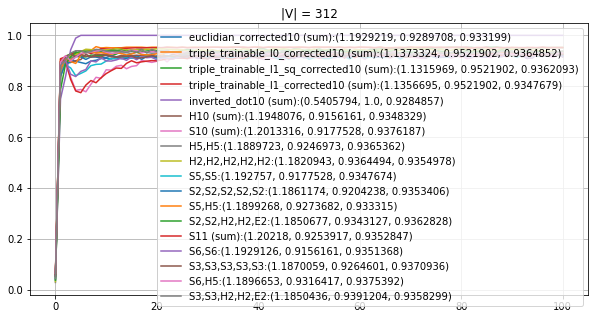


0.9289708	euclidian_corrected10 (sum)
0.9521902	triple_trainable_l0_corrected10 (sum)
0.9521902	triple_trainable_l1_sq_corrected10 (sum)
0.9521902	triple_trainable_l1_corrected10 (sum)
1.0	inverted_dot10 (sum)
0.9156161	H10 (sum)
0.9177528	S10 (sum)
0.9246973	H5,H5
0.9364494	H2,H2,H2,H2,H2
0.9177528	S5,S5
0.9204238	S2,S2,S2,S2,S2
0.9273682	S5,H5
0.9343127	S2,S2,H2,H2,E2
0.9253917	S11 (sum)
0.9156161	S6,S6
0.9264601	S3,S3,S3,S3,S3
0.9316417	S6,H5
0.9391204	S3,S3,H2,H2,E2


In [14]:
total_loss_story = utils.estimate_signatures_softmax(
    make_model_2, qs, distances_matrix=distances_matrix, r_matrix=r_matrix,
    dists=make_distances()+make_distances_3(), iters=2000, learning_rate=0.01,
    loss_eval_interval=20, draw_interval=20,
    print_results=True, different_d_sum=True
)

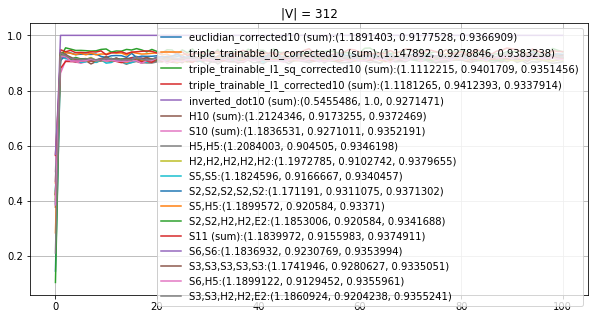

0.9177528	euclidian_corrected10 (sum)
0.9278846	triple_trainable_l0_corrected10 (sum)
0.9401709	triple_trainable_l1_sq_corrected10 (sum)
0.9412393	triple_trainable_l1_corrected10 (sum)
1.0	inverted_dot10 (sum)
0.9173255	H10 (sum)
0.9271011	S10 (sum)
0.904505	H5,H5
0.9102742	H2,H2,H2,H2,H2
0.9166667	S5,S5
0.9311075	S2,S2,S2,S2,S2
0.920584	S5,H5
0.920584	S2,S2,H2,H2,E2
0.9155983	S11 (sum)
0.9230769	S6,S6
0.9280627	S3,S3,S3,S3,S3
0.9129452	S6,H5
0.9204238	S3,S3,H2,H2,E2


In [16]:
total_loss_story2 = utils.estimate_signatures_softmax(
    make_model_2, qs, distances_matrix=distances_matrix, r_matrix=r_matrix,
    dists=make_distances()+make_distances_3(), iters=2000, learning_rate=0.1,
    loss_eval_interval=20, draw_interval=20,
    print_results=True, different_d_sum=True
)

In [17]:
for d, l0, l1 in zip(make_distances()+make_distances_3(), total_loss_story, total_loss_story2):
    ar = np.array([x[-1] for x in [l0, l1]])
    # print(f"{ar[:, 0].argmin(), ar[:, 1:].argmax(axis=0)}\t{d}")
    print(f"{ar[:, 0].min(), *ar[:, 1:].max(axis=0)}\t{d}")

(1.1891403, 0.9289708, 0.9366909)	euclidian_corrected10 (sum)
(1.1373324, 0.9521902, 0.9383238)	triple_trainable_l0_corrected10 (sum)
(1.1112215, 0.9521902, 0.9362093)	triple_trainable_l1_sq_corrected10 (sum)
(1.1181265, 0.9521902, 0.9347679)	triple_trainable_l1_corrected10 (sum)
(0.5405794, 1.0, 0.9284857)	inverted_dot10 (sum)
(1.1948076, 0.9173255, 0.9372469)	H10 (sum)
(1.1836531, 0.9271011, 0.9376187)	S10 (sum)
(1.1889723, 0.9246973, 0.9365362)	H5,H5
(1.1820943, 0.9364494, 0.9379655)	H2,H2,H2,H2,H2
(1.1824596, 0.9177528, 0.9347674)	S5,S5
(1.171191, 0.9311075, 0.9371302)	S2,S2,S2,S2,S2
(1.1899268, 0.9273682, 0.93371)	S5,H5
(1.1850677, 0.9343127, 0.9362828)	S2,S2,H2,H2,E2
(1.1839972, 0.9253917, 0.9374911)	S11 (sum)
(1.1836932, 0.9230769, 0.9353994)	S6,S6
(1.1741946, 0.9280627, 0.9370936)	S3,S3,S3,S3,S3
(1.1896653, 0.9316417, 0.9375392)	S6,H5
(1.1850436, 0.9391204, 0.9358299)	S3,S3,H2,H2,E2


### BONUS: сosine = sphere or not?

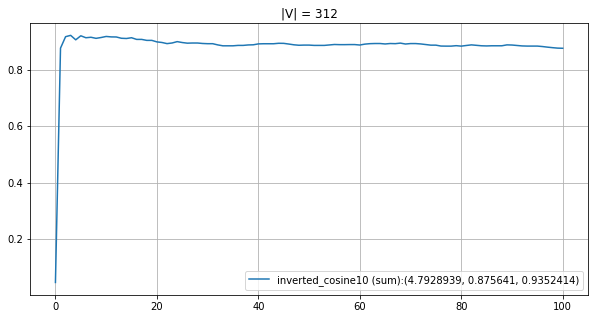


0.875641	inverted_cosine10 (sum)


In [27]:
total_loss_story = utils.estimate_signatures_softmax(
    make_model_2, qs, distances_matrix=distances_matrix, r_matrix=r_matrix,
    dists=[
        ProductDistances([
            (10, Distances("inverted_cosine", scalable=False))
        ], "sum"),
    ], iters=2000, learning_rate=0.01,
    loss_eval_interval=20, draw_interval=20,
    print_results=True, different_d_sum=True
)

need another LR... 1e-4 seems best

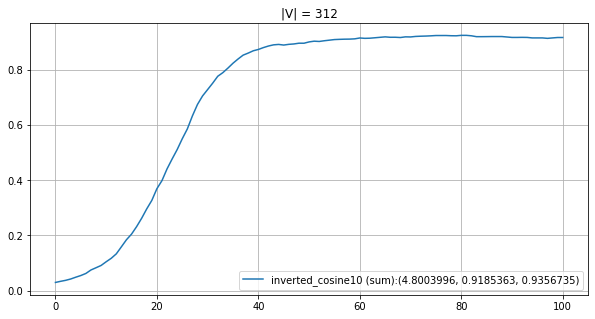


0.9185363	inverted_cosine10 (sum)


In [29]:
total_loss_story = utils.estimate_signatures_softmax(
    make_model_2, qs, distances_matrix=distances_matrix, r_matrix=r_matrix,
    dists=[
        ProductDistances([
            (10, Distances("inverted_cosine", scalable=False))
        ], "sum"),
    ], iters=2000, learning_rate=1e-4,
    loss_eval_interval=20, draw_interval=20,
    print_results=True, different_d_sum=True
)

Seems like sphere. What if we enable trainable coefficient?

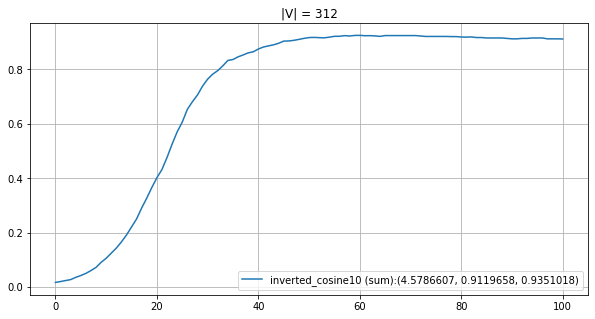


0.9119658	inverted_cosine10 (sum)


In [31]:
total_loss_story = utils.estimate_signatures_softmax(
    make_model_2, qs, distances_matrix=distances_matrix, r_matrix=r_matrix,
    dists=[
        ProductDistances([
            (10, Distances("inverted_cosine", scalable=True))
        ], "sum"),
    ], iters=2000, learning_rate=1e-4,
    loss_eval_interval=20, draw_interval=20,
    print_results=True, different_d_sum=True
)

best try

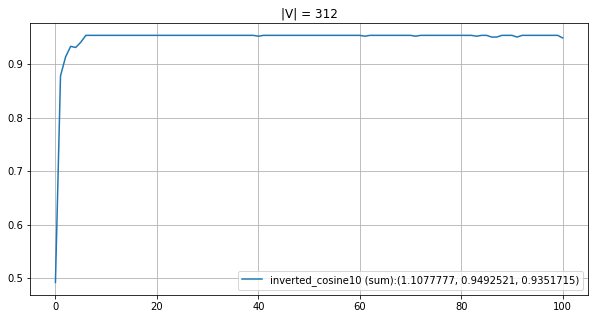

0.9492521	inverted_cosine10 (sum)


In [52]:
total_loss_story = utils.estimate_signatures_softmax(
    make_model_2, qs, distances_matrix=distances_matrix, r_matrix=r_matrix,
    dists=[
        ProductDistances([
            (10, Distances("inverted_cosine", scalable=True))
        ], "sum"),
    ], iters=2000, learning_rate=0.1,
    loss_eval_interval=20, draw_interval=20,
    print_results=True, different_d_sum=True
)

__________________

# CS PhDs

In [34]:
G, distances_matrix,r_matrix = utils.get_dataset(distances_matrix=True, edges_matrix=True)

Loading from ../datasets/CSPhDs.edges
|V| = 1025, |E| = 1043


In [35]:
make_model_g = lambda : make_model(len(G.nodes()))
d = make_model_g()
qs = d.sparse_arange(len(G.nodes()))

In [36]:
r_matrix

array([[0, 1, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [37]:
distances_matrix

array([[ 0,  1,  2, ..., 17, 17, 17],
       [ 1,  0,  1, ..., 16, 16, 16],
       [ 2,  1,  0, ..., 16, 16, 16],
       ...,
       [17, 16, 16, ...,  0,  2,  2],
       [17, 16, 16, ...,  2,  0,  2],
       [17, 16, 16, ...,  2,  2,  0]])

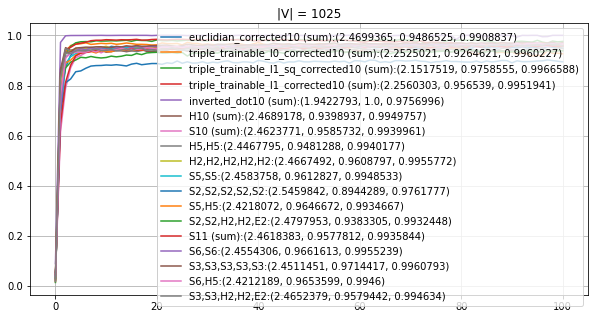

0.9486525	euclidian_corrected10 (sum)
0.9264621	triple_trainable_l0_corrected10 (sum)
0.9758555	triple_trainable_l1_sq_corrected10 (sum)
0.956539	triple_trainable_l1_corrected10 (sum)
1.0	inverted_dot10 (sum)
0.9398937	H10 (sum)
0.9585732	S10 (sum)
0.9481288	H5,H5
0.9608797	H2,H2,H2,H2,H2
0.9612827	S5,S5
0.8944289	S2,S2,S2,S2,S2
0.9646672	S5,H5
0.9383305	S2,S2,H2,H2,E2
0.9577812	S11 (sum)
0.9661613	S6,S6
0.9714417	S3,S3,S3,S3,S3
0.9653599	S6,H5
0.9579442	S3,S3,H2,H2,E2


In [22]:
total_loss_story = utils.estimate_signatures_softmax(
    make_model_2, qs, distances_matrix=distances_matrix, r_matrix=r_matrix,
    dists=make_distances()+make_distances_3(), iters=2000, learning_rate=0.1,
    loss_eval_interval=20, draw_interval=20,
    print_results=True, different_d_sum=True
)

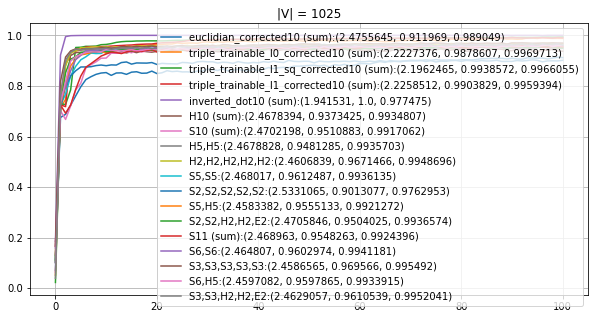

0.911969	euclidian_corrected10 (sum)
0.9878607	triple_trainable_l0_corrected10 (sum)
0.9938572	triple_trainable_l1_sq_corrected10 (sum)
0.9903829	triple_trainable_l1_corrected10 (sum)
1.0	inverted_dot10 (sum)
0.9373425	H10 (sum)
0.9510883	S10 (sum)
0.9481285	H5,H5
0.9671466	H2,H2,H2,H2,H2
0.9612487	S5,S5
0.9013077	S2,S2,S2,S2,S2
0.9555133	S5,H5
0.9504025	S2,S2,H2,H2,E2
0.9548263	S11 (sum)
0.9602974	S6,S6
0.969566	S3,S3,S3,S3,S3
0.9597865	S6,H5
0.9610539	S3,S3,H2,H2,E2


In [28]:
total_loss_story2 = utils.estimate_signatures_softmax(
    make_model_2, qs, distances_matrix=distances_matrix, r_matrix=r_matrix,
    dists=make_distances()+make_distances_3(), iters=2000, learning_rate=0.05,
    loss_eval_interval=20, draw_interval=20,
    print_results=True, different_d_sum=True
)

In [30]:
for d, l0, l1 in zip(make_distances()+make_distances_3(), total_loss_story, total_loss_story2):
    ar = np.array([x[-1] for x in [l0, l1]])
    # print(f"{ar[:, 0].argmin(), ar[:, 1:].argmax(axis=0)}\t{d}")
    print(f"{ar[:, 0].min(), *ar[:, 1:].max(axis=0)}\t{d}")

(2.4699365, 0.9486525, 0.9908837)	euclidian_corrected10 (sum)
(2.2227376, 0.9878607, 0.9969713)	triple_trainable_l0_corrected10 (sum)
(2.1517519, 0.9938572, 0.9966588)	triple_trainable_l1_sq_corrected10 (sum)
(2.2258512, 0.9903829, 0.9959394)	triple_trainable_l1_corrected10 (sum)
(1.941531, 1.0, 0.977475)	inverted_dot10 (sum)
(2.4678394, 0.9398937, 0.9949757)	H10 (sum)
(2.4623771, 0.9585732, 0.9939961)	S10 (sum)
(2.4467795, 0.9481288, 0.9940177)	H5,H5
(2.4606839, 0.9671466, 0.9955772)	H2,H2,H2,H2,H2
(2.4583758, 0.9612827, 0.9948533)	S5,S5
(2.5331065, 0.9013077, 0.9762953)	S2,S2,S2,S2,S2
(2.4218072, 0.9646672, 0.9934667)	S5,H5
(2.4705846, 0.9504025, 0.9936574)	S2,S2,H2,H2,E2
(2.4618383, 0.9577812, 0.9935844)	S11 (sum)
(2.4554306, 0.9661613, 0.9955239)	S6,S6
(2.4511451, 0.9714417, 0.9960793)	S3,S3,S3,S3,S3
(2.4212189, 0.9653599, 0.9946)	S6,H5
(2.4629057, 0.9610539, 0.9952041)	S3,S3,H2,H2,E2


### BONUS 2: cosine

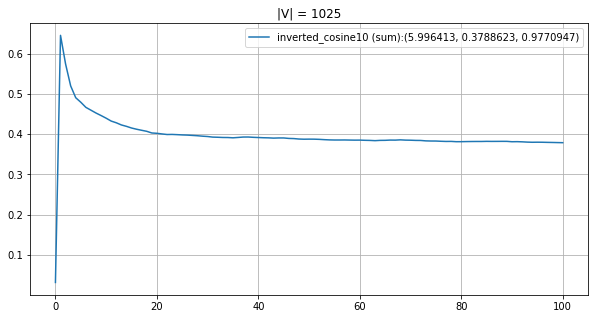

0.3788623	inverted_cosine10 (sum)


In [43]:
total_loss_story = utils.estimate_signatures_softmax(
    make_model_2, qs, distances_matrix=distances_matrix, r_matrix=r_matrix,
    dists=[
        ProductDistances([
            (10, Distances("inverted_cosine", scalable=False))
        ], "sum"),
    ], iters=2000, learning_rate=0.01,
    loss_eval_interval=20, draw_interval=20,
    print_results=True, different_d_sum=True
)

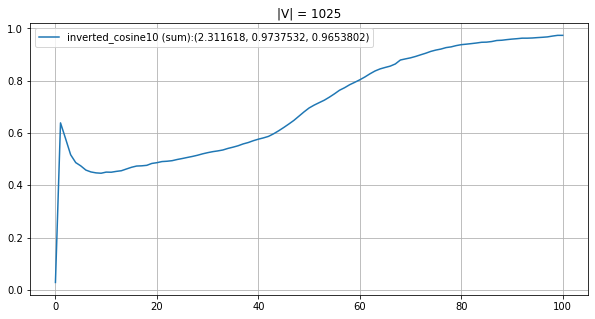

0.9737532	inverted_cosine10 (sum)


In [44]:
total_loss_story = utils.estimate_signatures_softmax(
    make_model_2, qs, distances_matrix=distances_matrix, r_matrix=r_matrix,
    dists=[
        ProductDistances([
            (10, Distances("inverted_cosine", scalable=True))
        ], "sum"),
    ], iters=2000, learning_rate=0.01,
    loss_eval_interval=20, draw_interval=20,
    print_results=True, different_d_sum=True
)

best try (a lot of LR tuning)

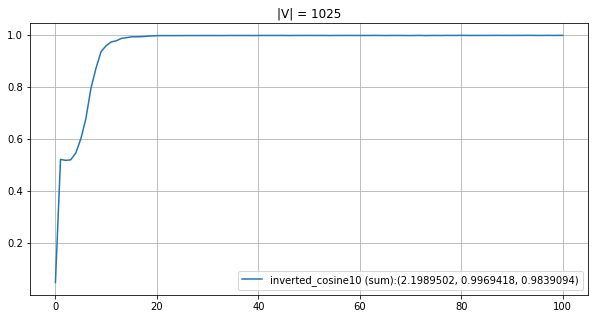

0.9969418	inverted_cosine10 (sum)


In [45]:
total_loss_story = utils.estimate_signatures_softmax(
    make_model_2, qs, distances_matrix=distances_matrix, r_matrix=r_matrix,
    dists=[
        ProductDistances([
            (10, Distances("inverted_cosine", scalable=True))
        ], "sum"),
    ], iters=2000, learning_rate=0.1,
    loss_eval_interval=20, draw_interval=20,
    print_results=True, different_d_sum=True
)

__________________

# POWER

In [31]:
G, distances_matrix, r_matrix = utils.get_dataset("power", distances_matrix=True, edges_matrix=True)

Loading from ../datasets/power.edges
|V| = 4941, |E| = 6594


In [32]:
distances_matrix

array([[ 0,  1,  1, ..., 10, 14, 14],
       [ 1,  0,  2, ...,  9, 13, 13],
       [ 1,  2,  0, ..., 11, 15, 15],
       ...,
       [10,  9, 11, ...,  0, 11, 11],
       [14, 13, 15, ..., 11,  0,  2],
       [14, 13, 15, ..., 11,  2,  0]])

In [33]:
r_matrix

array([[0, 1, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [34]:
make_model_g = lambda : make_model(len(G.nodes()))
def make_model_g2(emb_size=10):
    return make_model_2(emb_size=emb_size, l=len(G.nodes()))

d = make_model_g()
qs = d.sparse_arange(len(G.nodes()))  # queries

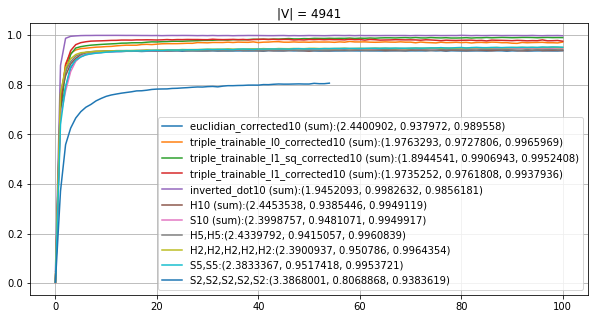

1081:3.3867367100123658
1082:3.386651451815896
1083:3.3866519385972764
1084:3.386582043988382
1085:3.3865655849556653
1086:3.3865375588594406
1087:3.386509584635443
1088:3.386450886180615
1089:3.386457790675695
1090:3.3863936869716644
1091:3.3863516914407703
1092:3.386371374490824
1093:3.3863041914539553
1094:3.386272521478716
1095:3.386277216642695


In [ ]:
total_loss_story_p1 = utils.estimate_signatures_softmax(
    make_model, qs, distances_matrix=distances_matrix, r_matrix=r_matrix,
    dists=make_distances(), iters=2000, learning_rate=0.1,
    loss_eval_interval=20, draw_interval=20
)

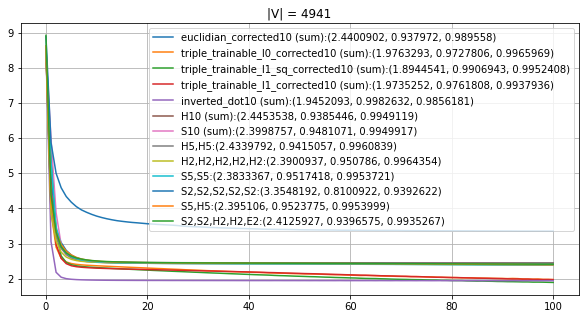

In [21]:
# fuck'in connection (image )
dists = make_distances()
plt.figure(figsize=(10, 5))
plt.title(f"|V| = {qs.shape[0]}")
for i, prev_loss_story in enumerate(total_loss_story_p1):
    plt.plot([x[0] for x in prev_loss_story], label=f"{dists[i]}:{prev_loss_story[-1]}")
plt.legend()
plt.grid()
clear_output()
plt.show()

In [26]:
for d, l in zip(make_distances(), total_loss_story_p1):
    print(f"{l[-1]}\t{d}")

(2.4400902, 0.937972, 0.989558)	euclidian_corrected10 (sum)
(1.9763293, 0.9727806, 0.9965969)	triple_trainable_l0_corrected10 (sum)
(1.8944541, 0.9906943, 0.9952408)	triple_trainable_l1_sq_corrected10 (sum)
(1.9735252, 0.9761808, 0.9937936)	triple_trainable_l1_corrected10 (sum)
(1.9452093, 0.9982632, 0.9856181)	inverted_dot10 (sum)
(2.4453538, 0.9385446, 0.9949119)	H10 (sum)
(2.3998757, 0.9481071, 0.9949917)	S10 (sum)
(2.4339792, 0.9415057, 0.9960839)	H5,H5
(2.3900937, 0.950786, 0.9964354)	H2,H2,H2,H2,H2
(2.3833367, 0.9517418, 0.9953721)	S5,S5
(3.3548192, 0.8100922, 0.9392622)	S2,S2,S2,S2,S2
(2.395106, 0.9523775, 0.9953999)	S5,H5
(2.4125927, 0.9396575, 0.9935267)	S2,S2,H2,H2,E2


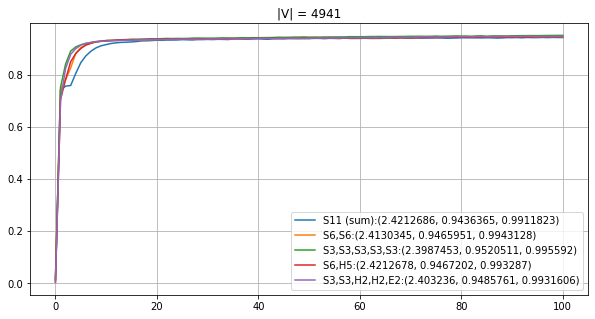

0.9436365	S11 (sum)
0.9465951	S6,S6
0.9520511	S3,S3,S3,S3,S3
0.9467202	S6,H5
0.9485761	S3,S3,H2,H2,E2


In [35]:
total_loss_story2 = utils.estimate_signatures_softmax(
    make_model_2, qs, distances_matrix=distances_matrix, r_matrix=r_matrix,
    dists=make_distances_3(), iters=2000, learning_rate=0.05,
    loss_eval_interval=20, draw_interval=20,
    print_results=True, different_d_sum=True
)

_______________________

# Facebook

In [36]:
G, distances_matrix = utils.get_dataset("facebook", distances_matrix=True)

Loading from ../datasets/facebook.edges
|V| = 4039, |E| = 88234


In [37]:
make_model_g = lambda : make_model(len(G.nodes()))
def make_model_g2(emb_size=10):
    return make_model_2(emb_size=emb_size, l=len(G.nodes()))

d = make_model_g()
qs = d.sparse_arange(len(G.nodes()))  # queries
r_matrix = 1 * (distances_matrix <= 1.001)
distances_matrix.shape

(4039, 4039)

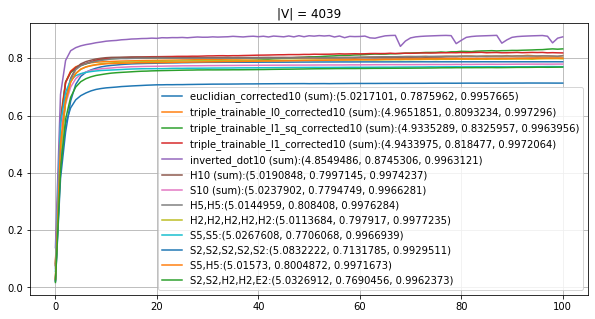

In [29]:
total_loss_story_f1 = utils.estimate_signatures_softmax(
    make_model, qs, distances_matrix=distances_matrix, r_matrix=r_matrix,
    dists=make_distances(), iters=2000, learning_rate=0.1,
    loss_eval_interval=20, draw_interval=20
)

In [34]:
for d, l in zip(make_distances(), total_loss_story_f1):
    print(f"{l[-1]}\t{d}")

(5.0217101, 0.7875962, 0.9957665)	euclidian_corrected10 (sum)
(4.9651851, 0.8093234, 0.997296)	triple_trainable_l0_corrected10 (sum)
(4.9335289, 0.8325957, 0.9963956)	triple_trainable_l1_sq_corrected10 (sum)
(4.9433975, 0.818477, 0.9972064)	triple_trainable_l1_corrected10 (sum)
(4.8549486, 0.8745306, 0.9963121)	inverted_dot10 (sum)
(5.0190848, 0.7997145, 0.9974237)	H10 (sum)
(5.0237902, 0.7794749, 0.9966281)	S10 (sum)
(5.0144959, 0.808408, 0.9976284)	H5,H5
(5.0113684, 0.797917, 0.9977235)	H2,H2,H2,H2,H2
(5.0267608, 0.7706068, 0.9966939)	S5,S5
(5.0832222, 0.7131785, 0.9929511)	S2,S2,S2,S2,S2
(5.01573, 0.8004872, 0.9971673)	S5,H5
(5.0326912, 0.7690456, 0.9962373)	S2,S2,H2,H2,E2


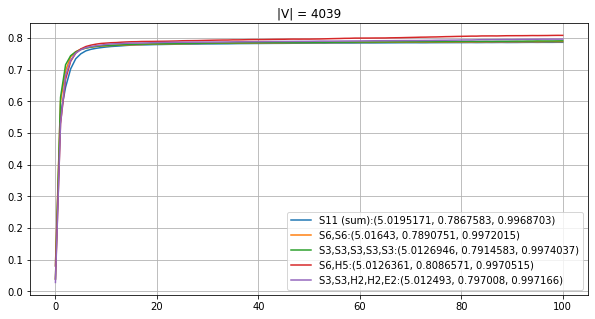

0.7867583	S11 (sum)
0.7890751	S6,S6
0.7914583	S3,S3,S3,S3,S3
0.8086571	S6,H5
0.797008	S3,S3,H2,H2,E2


In [38]:
total_loss_story2 = utils.estimate_signatures_softmax(
    make_model_2, qs, distances_matrix=distances_matrix, r_matrix=r_matrix,
    dists=make_distances_3(), iters=2000, learning_rate=0.1,
    loss_eval_interval=20, draw_interval=20,
    print_results=True, different_d_sum=True
)

______________________
## Wiki 
### aka WLA6 - bfs on Wikipedia categories from Linear Algebra, depth = 6

In [39]:
# !cp wiki.edges ../datasets/wla6.edges
# !cp wiki.nodes ../datasets/wla6.nodes

In [40]:
!head ../datasets/wla6.edges -n 3
!echo 
!head ../datasets/wla6.nodes -n 4

0	1
0	2
0	3

linear algebra
convex geometry
determinants
invariant subspaces


In [41]:
G, distances_matrix, r_matrix = utils.get_dataset("wla6", distances_matrix=True, edges_matrix=True)

Loading from ../datasets/wla6.edges
|V| = 3227, |E| = 3604


In [42]:
make_model_g = lambda : make_model(len(G.nodes()))
def make_model_g2(emb_size=10):
    return make_model_2(emb_size=emb_size, l=len(G.nodes()))

d = make_model_g()
qs = d.sparse_arange(len(G.nodes()))  # queries

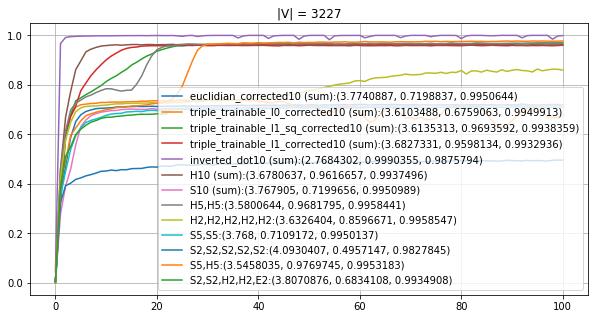

441:3.807123850671614


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [37]:
total_loss_story_w = utils.estimate_signatures_softmax(
    make_model, qs, distances_matrix=distances_matrix, r_matrix=r_matrix,
    dists=make_distances(), iters=2000, learning_rate=0.1,
    loss_eval_interval=20, draw_interval=20
)

In [38]:
for d, l in zip(make_distances(), total_loss_story_w):
    print(f"{l[-1]}\t{d}")

(3.7740887, 0.7198837, 0.9950644)	euclidian_corrected10 (sum)
(3.6103488, 0.6759063, 0.9949913)	triple_trainable_l0_corrected10 (sum)
(3.6135313, 0.9693592, 0.9938359)	triple_trainable_l1_sq_corrected10 (sum)
(3.6827331, 0.9598134, 0.9932936)	triple_trainable_l1_corrected10 (sum)
(2.7684302, 0.9990355, 0.9875794)	inverted_dot10 (sum)
(3.6780637, 0.9616657, 0.9937496)	H10 (sum)
(3.767905, 0.7199656, 0.9950989)	S10 (sum)
(3.5800644, 0.9681795, 0.9958441)	H5,H5
(3.6326404, 0.8596671, 0.9958547)	H2,H2,H2,H2,H2
(3.768, 0.7109172, 0.9950137)	S5,S5
(4.0930407, 0.4957147, 0.9827845)	S2,S2,S2,S2,S2
(3.5458035, 0.9769745, 0.9953183)	S5,H5
(3.7351644, 0.5876092, 0.9942551)	S2,S2,H2,H2,E2


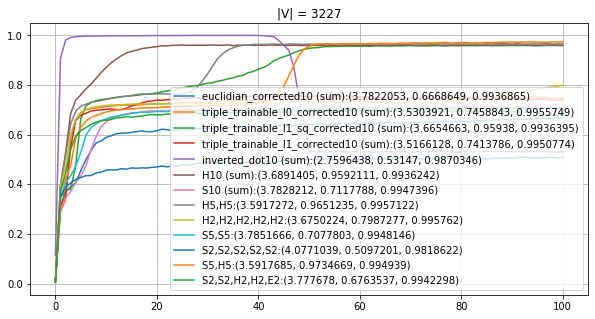

In [40]:
total_loss_story_w2 = utils.estimate_signatures_softmax(
    make_model, qs, distances_matrix=distances_matrix, r_matrix=r_matrix,
    dists=make_distances(), iters=2000, learning_rate=0.05,
    loss_eval_interval=20, draw_interval=20
)

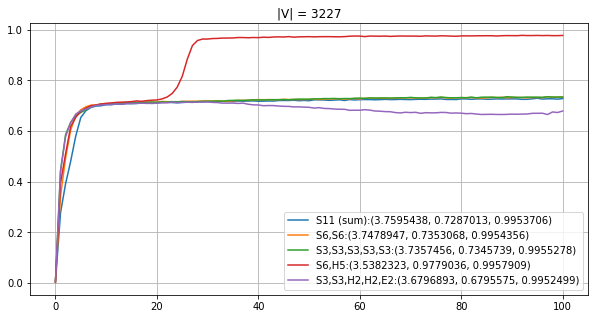

0.7287013	S11 (sum)
0.7353068	S6,S6
0.7345739	S3,S3,S3,S3,S3
0.9779036	S6,H5
0.6795575	S3,S3,H2,H2,E2


In [43]:
total_loss_story2 = utils.estimate_signatures_softmax(
    make_model_2, qs, distances_matrix=distances_matrix, r_matrix=r_matrix,
    dists=make_distances_3(), iters=2000, learning_rate=0.1,
    loss_eval_interval=20, draw_interval=20,
    print_results=True, different_d_sum=True
)